# Microscopy figures
This [Jupyter](http://jupyter.com) notebook was used to generate the microscopy figures for the [publication on the acinar complexity](https://www.authorea.com/274247/47HwqAxume3L2xkLOsg_SQ).

In [1]:
# Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import numpy
import timeit
import scipy.stats
import itertools

In [2]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [3]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the repository.'
      % the_current_git_hash)

We are working with version 9db5889 of the repository.


In [4]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
# plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...

In [5]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

Let's load the relevant data.
First we load the 'Count' data from Eveline.
This is what she assessed with the STEPanizer in tedious work.

In [6]:
# Different locations if running either on Linux or Windows
# ----
# We copied all the data 'nas_schittny' and 'anatera4' to the internal 'fast SSD' with
# ---
# rsync -av -m --include='**/' --include='**/*5slices/**' --exclude='*' '/run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/' '/media/habi/Fast_SSD/Acini/'
# (obviously only works on Linux)
# ---
# so we can set
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        RootPath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'Acini')
    else:
        RootPath = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny', 'doc', 'David')
else:
    if FastSSD:
        RootPath = os.path.join('F:/', 'Acini')
    else:
        RootPath = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data', 'doc', 'David')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [7]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    location_volumes = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    location_volumes = '\\\\anatera4\\'
# Load the data from this folder
terastation = location_volumes + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [8]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Fortunately, she did NOT count in 2018
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath, '**/*201[1234567]*.xls'), recursive=True))
if len(StepanizerFiles_Eveline):
    print('Eveline counted the alveoli in %s acini in total.' % len(StepanizerFiles_Eveline))
else:
    print('Mount the fast SSD please!!!')

Eveline counted the alveoli in 287 acini in total.


----

Get a sampler of the tomography slices to compare them with microscopy slides.
E.g., get *one* acinus per day, get the middle image of it and then image this *physical* slice on the microscope.
(We got the slices from Stefan...)
This if for the 'Comparison Images' at the end of the results.

In [9]:
Microscopy = pandas.DataFrame({'File': StepanizerFiles_Eveline})
Microscopy['Location'] = [os.path.dirname(f) for f in Microscopy.File]
Microscopy['NumImages'] = [len(glob.glob(os.path.join(f, '*.jpg'))) for f in Microscopy.Location]
Microscopy['MiddleImage'] = Microscopy.NumImages // 4  # we have _a and _b series, so half of it is the image set, and again half of it is the middle image
Microscopy['SelectedImage'] = [glob.glob(os.path.join(f, '*' + str(mi) + '_a.jpg'))[0] for f, mi in zip(Microscopy.Location, Microscopy.MiddleImage)]
Microscopy['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in Microscopy.File]
Microscopy['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in Microscopy.File]
Microscopy['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in Microscopy.File]
Microscopy['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in Microscopy.File]

In [10]:
Microscopy.head()

,File,Location,NumImages,MiddleImage,SelectedImage,Sample,Animal,Day,Acinus
0,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,186,46,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,R108C60Dt-mrg,60D,60,3
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,264,66,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,R108C60Dt-mrg,60D,60,4
2,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,240,60,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,R108C60Dt-mrg,60D,60,7
3,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,248,62,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,R108C60Dt-mrg,60D,60,9
4,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,220,55,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,R108C60Dt-mrg,60D,60,10


In [11]:
# Select one random sample per day (e.g. one random acinus)
# Based on https://stackoverflow.com/a/41566012/323100
Subset = Microscopy.groupby('Day').apply(lambda x: x.sample())

In [12]:
print('Image slices from these samples')
for c, i in Subset.iterrows():
    print('\t- From sample', i.Sample, 'we show Acinus\t', i.Acinus)

Image slices from these samples
	- From sample R108C04At-mrg we show Acinus	 45
	- From sample R108C10C_B1_mrg we show Acinus	 61
	- From sample R108C21Bt-mrg we show Acinus	 32
	- From sample R108C60C_B1-mrg we show Acinus	 10


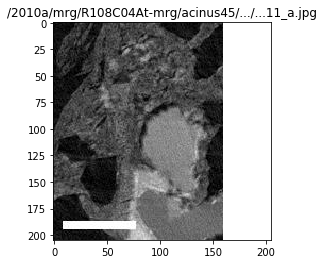

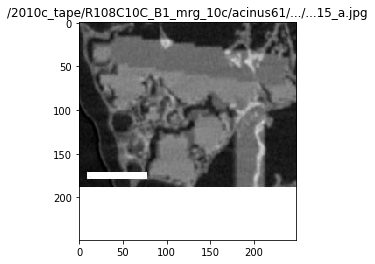

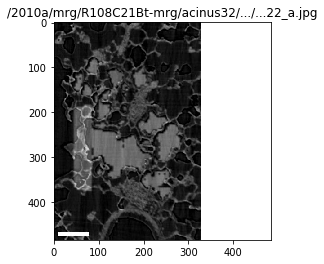

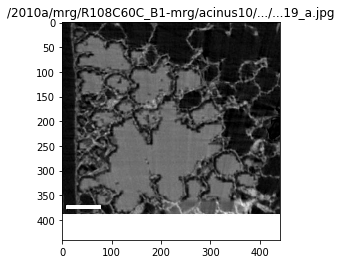

In [13]:
for c, i in enumerate(Subset['SelectedImage']):
    plt.imshow(plt.imread(i))
    plt.title(os.path.dirname(Subset['Location'][c][len(RootPath):]) + '/.../...' + os.path.basename(Subset['SelectedImage'][c][-8:]))
    plt.show()

For *one* animal per day (selected randomly above) we imaged the middle slice of Stefans lung slices (usually slice nr. 8) on the microscope.
The code below is used to get the middle disector-slice and the bottom TOMCAT reconstruction of exactly these samples and copy them to the 'Microscopy' subfolder for generating the relevant figures.

In [14]:
SamplesImaged = ['R108C04At-mrg',
                 'R108C10C_B1_mrg',
                 'R108C21E_B1_mrg',
                 'R108C60C_B1-mrg']

In [15]:
AciniImaged = [39, 32, 38, 4]

In [16]:
# We could do the selection of the relevant items from the dataframe a bit more clever
# But since we didn't think about it before, we just loop through the frame four times in a row :)
Indices = [None] * len(SamplesImaged)
for smpl in range(len(SamplesImaged)):
    for idx, row in Microscopy.iterrows():
        if row.Sample in SamplesImaged[smpl]:
            if row.Acinus == AciniImaged[smpl]:
                Indices[smpl] = idx
    print('Found acinus %s of sample %s at item %s of "Microscopy" dataframe' % (AciniImaged[smpl],
                                                                                 SamplesImaged[smpl],
                                                                                 Indices[smpl]))

Found acinus 39 of sample R108C04At-mrg at item 33 of "Microscopy" dataframe
Found acinus 32 of sample R108C10C_B1_mrg at item 225 of "Microscopy" dataframe
Found acinus 38 of sample R108C21E_B1_mrg at item 259 of "Microscopy" dataframe
Found acinus 4 of sample R108C60C_B1-mrg at item 201 of "Microscopy" dataframe


In [17]:
for i in Indices:
    print(Microscopy.iloc[i])
    print(80 * '-')

File             /media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...
Location         /media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...
NumImages                                                       20
MiddleImage                                                      5
SelectedImage    /media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...
Sample                                               R108C04At-mrg
Animal                                                         04A
Day                                                              4
Acinus                                                          39
Name: 33, dtype: object
--------------------------------------------------------------------------------
File             /media/habi/Fast_SSD/Acini/2010c_tape/R108C10C...
Location         /media/habi/Fast_SSD/Acini/2010c_tape/R108C10C...
NumImages                                                       70
MiddleImage                                                     17
SelectedImage    /media/

In [18]:
for i in Indices:
    print(Microscopy.iloc[i].SelectedImage)
    print(80 * '-')

/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At-mrg/acinus39/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C04At-mrg-acinus39_5_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010c_tape/R108C10C_B1_mrg_10c/acinus32/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C10C_B1_mrg-acinus32_17_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010c_tape/R108C21E_B1_mrg_10c/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C21E_B1_mrg-acinus38_28_a.jpg
--------------------------------------------------------------------------------
/media/habi/Fast_SSD/Acini/2010a/mrg/R108C60C_B1-mrg/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C60C_B1-mrg-acinus04_21_a.jpg
--------------------------------------------------------------------------------


In [19]:
# Copy acinus images to Microscopy subfolder
from shutil import copyfile
for i in Indices:
    print('Copying %s to "Originals_TOMCAT" subfolder' % Microscopy.iloc[i].SelectedImage)
    copyfile(Microscopy.iloc[i].SelectedImage,
             os.path.join('Microscopy', 'Originals_TOMCAT', os.path.basename(Microscopy.iloc[i].SelectedImage)))

Copying /media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At-mrg/acinus39/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C04At-mrg-acinus39_5_a.jpg to "Originals_TOMCAT" subfolder
Copying /media/habi/Fast_SSD/Acini/2010c_tape/R108C10C_B1_mrg_10c/acinus32/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C10C_B1_mrg-acinus32_17_a.jpg to "Originals_TOMCAT" subfolder
Copying /media/habi/Fast_SSD/Acini/2010c_tape/R108C21E_B1_mrg_10c/acinus38/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C21E_B1_mrg-acinus38_28_a.jpg to "Originals_TOMCAT" subfolder
Copying /media/habi/Fast_SSD/Acini/2010a/mrg/R108C60C_B1-mrg/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices/R108C60C_B1-mrg-acinus04_21_a.jpg to "Originals_TOMCAT" subfolder


In [20]:
# Copy bottom reconstruction of top scan from selected sample to Microscopy subfolder
for i in Indices:
    # Do some string manipulation to get us the correct directory
    lookuppath = terastation + os.path.join(os.path.dirname(os.path.dirname(Microscopy.iloc[i].Location[len(RootPath):])),
                                            'rec_8bit')
    # Get all the files in there, sorted
    files = sorted(glob.glob(os.path.join(lookuppath, '*.tif')))
    # The last file is the bottom image of the top stack, copy this one, now
    print('Copying %s to "Originals_TOMCAT" subfolder' % files[-1])
    copyfile(files[-1],
             os.path.join('Microscopy', 'Originals_TOMCAT', os.path.basename(files[-1])))

Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010a/mrg/R108C04At-mrg/rec_8bit/R108C04At-mrg1024.rec.8bit.tif to "Originals_TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010c_tape/R108C10C_B1_mrg_10c/rec_8bit/R108C10C_B1_mrg1024.rec.8bit.tif to "Originals_TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010c_tape/R108C21E_B1_mrg_10c/rec_8bit/R108C21E_B1_mrg1024.rec.8bit.tif to "Originals_TOMCAT" subfolder
Copying /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS/2010a/mrg/R108C60C_B1-mrg/rec_8bit/R108C60C_B1-mrg1024.rec.8bit.tif to "Originals_TOMCAT" subfolder


In [21]:
print('Done with everything, now go LaTeXing the figures!')

Done with everything, now go LaTeXing the figures!
